# CNN to classify cats and dogs



In [1]:
!curl https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip --output Cat_Dog_data.zip
!unzip Cat_Dog_data.zip -d Cat_Dog_data

Streaming output truncated to the last 5000 lines.
  inflating: Cat_Dog_data/Cat_Dog_data/train/dog/dog.8636.jpg  
  inflating: Cat_Dog_data/__MACOSX/Cat_Dog_data/train/dog/._dog.8636.jpg  
  inflating: Cat_Dog_data/Cat_Dog_data/train/dog/dog.7505.jpg  
  inflating: Cat_Dog_data/__MACOSX/Cat_Dog_data/train/dog/._dog.7505.jpg  
  inflating: Cat_Dog_data/Cat_Dog_data/train/dog/dog.1174.jpg  
  inflating: Cat_Dog_data/__MACOSX/Cat_Dog_data/train/dog/._dog.1174.jpg  
  inflating: Cat_Dog_data/Cat_Dog_data/train/dog/dog.9528.jpg  
  inflating: Cat_Dog_data/__MACOSX/Cat_Dog_data/train/dog/._dog.9528.jpg  
  inflating: Cat_Dog_data/Cat_Dog_data/train/dog/dog.1612.jpg  
  inflating: Cat_Dog_data/__MACOSX/Cat_Dog_data/train/dog/._dog.1612.jpg  
  inflating: Cat_Dog_data/Cat_Dog_data/train/dog/dog.8150.jpg  
  inflating: Cat_Dog_data/__MACOSX/Cat_Dog_data/train/dog/._dog.8150.jpg  
  inflating: Cat_Dog_data/Cat_Dog_data/train/dog/dog.7263.jpg  
  inflating: Cat_Dog_data/__MACOSX/Cat_Dog_data/tra

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchsummary import summary
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
from pathlib import Path

In [3]:
# Constants
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.0001
EPOCHS = 20
LOSS_FUNCTION = nn.CrossEntropyLoss()
TRAIN_TRANSFORMS = transforms.Compose([transforms.RandomHorizontalFlip(p=0.4),
                                 transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.ToTensor()])
TEST_TRANSFORMS = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor()])

## Utility Functions

In [4]:
def viewer(images, labels):
  labelcheck= {0:"Cat",
               1:"Dog"}
  fig = plt.figure(figsize=(15,15), dpi= 65)
  
  for idx, (image, label) in enumerate(zip(images, labels)):
    image = image.numpy().transpose((1, 2, 0))
    if (idx>4):
      fig.add_subplot(2,5,idx-4)
    else:
      fig.add_subplot(1,5,idx+1)
    plt.axis('off')
    plt.title(labelcheck[int(label)])
    plt.imshow(image)
  fig.tight_layout()
  plt.show()  

In [5]:
train_dir = Path('/content/Cat_Dog_data/Cat_Dog_data/train')
test_dir = Path('/content/Cat_Dog_data/Cat_Dog_data/test')

train_df = pd.DataFrame(columns=['Labels', 'Count of Images'])
test_df = pd.DataFrame(columns=['Labels', 'Count of Images'])

train_path = [str(img_path) for img_path in train_dir.glob('**/*.jpg')]
test_path = [str(img_path) for img_path in test_dir.glob('**/*.jpg')]

train_set_labels = [os.path.split(os.path.split(img_path)[0])[1] for img_path in train_path]
test_set_labels = [os.path.split(os.path.split(img_path)[0])[1] for img_path in test_path]
labels = list(set(test_set_labels))

for label in labels:
  train_count = train_set_labels.count(label)
  test_count = test_set_labels.count(label)
  train_df.loc[len(train_df.index)] = [label, train_count]
  test_df.loc[len(test_df.index)] = [label, test_count]

print("Train set Details")
display(train_df)
print("\nTest set Details")
display(test_df)

Train set Details


,Labels,Count of Images
0,cat,11250
1,dog,11250



Test set Details


,Labels,Count of Images
0,cat,1250
1,dog,1250


## DataLoaders


In [6]:
train_set = ImageFolder(train_dir, transform=TRAIN_TRANSFORMS)
test_set = ImageFolder(test_dir, transform=TEST_TRANSFORMS)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

## Dataset Samples

Viewing 10 samples from the Train Dataset


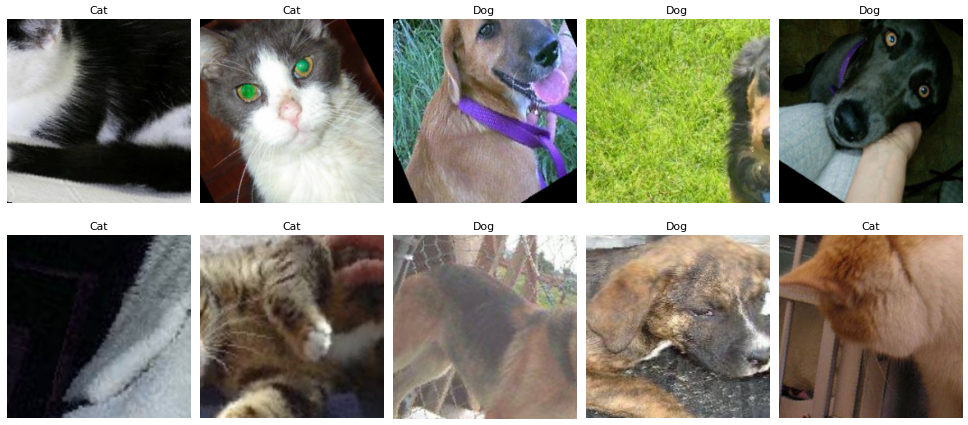


Viewing 10 samples from the Test Dataset



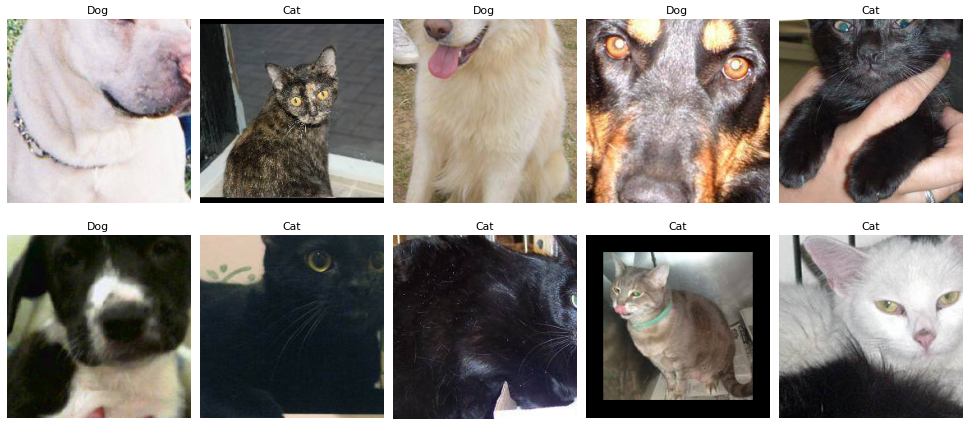

In [ ]:
print("Viewing 10 samples from the Train Dataset")
images, labels = next(iter(train_loader))
viewer(images[0:10], labels[0:10])

print("\nViewing 10 samples from the Test Dataset\n")
images, labels = next(iter(test_loader))
viewer(images[0:10], labels[0:10])

## Creating a model

In [ ]:
model = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(2,2),
                      nn.Conv2d(128, 256, kernel_size=2, stride=1),
                      nn.LeakyReLU(inplace=True),
                      nn.Conv2d(256, 256, kernel_size=3, stride=2),
                      nn.LeakyReLU(inplace=True),
                      nn.MaxPool2d(2,2),
                      nn.Flatten(),
                      nn.Linear(256*6*6, 576),
                      nn.ReLU(inplace=True),
                      nn.Linear(576, 2)
                      )

model.to(device=DEVICE)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
              ReLU-2         [-1, 64, 112, 112]               0
            Conv2d-3          [-1, 128, 56, 56]          73,856
              ReLU-4          [-1, 128, 56, 56]               0
         MaxPool2d-5          [-1, 128, 28, 28]               0
            Conv2d-6          [-1, 256, 27, 27]         131,328
         LeakyReLU-7          [-1, 256, 27, 27]               0
            Conv2d-8          [-1, 256, 13, 13]         590,080
         LeakyReLU-9          [-1, 256, 13, 13]               0
        MaxPool2d-10            [-1, 256, 6, 6]               0
          Flatten-11                 [-1, 9216]               0
           Linear-12                  [-1, 576]       5,308,992
             ReLU-13                  [-1, 576]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Training the Model

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.train()

avg_loss = 0
avg_accuracy = 0

for epoch in range(EPOCHS):
  loop = tqdm(train_loader)
  epoch_accuracy = 0
  epoch_loss = 0
  batch_length = len(loop)
  for batch_idx, (images, labels) in enumerate(loop):
    optimizer.zero_grad()

    images = images.to(device=DEVICE)
    labels = labels.to(device=DEVICE)

    outputs = model(images)
    loss = LOSS_FUNCTION(outputs, labels)
    loss.backward()
    optimizer.step()

    outputs = torch.sigmoid(outputs)
    output_perc, output_label = torch.max(outputs, 1)


    epoch_accuracy += torch.mean((output_label == labels).type(torch.FloatTensor)).item()
    epoch_loss += loss.item()
    
    loop.set_postfix(loss=epoch_loss/(batch_idx+1), accuracy=epoch_accuracy*100/(batch_idx+1), batch_no=batch_idx+1)

  torch.cuda.empty_cache()
  avg_loss = avg_loss + epoch_loss/batch_length
  avg_accuracy = avg_accuracy + epoch_accuracy/batch_length

print("\nAverage trainging loss is {} \nAverage training accuracy is {}%".format((avg_loss/EPOCHS), (avg_accuracy*100/EPOCHS)))
    

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]


Average trainging loss is 0.5021258252016693 
Average training accuracy is 74.51899364717643%


## Testing the trained model

In [ ]:
avg_accuracy = 0
model.eval()
with torch.no_grad():
  loop = tqdm(test_loader)
  batch_length = len(loop)
  accuracy = 0

  for batch_idx, (images, labels) in enumerate(loop):
    images = images.to(device=DEVICE)
    labels = labels.to(device=DEVICE)

    outputs = model(images)
    outputs = torch.sigmoid(outputs)
    output_perc, output_label = torch.max(outputs, 1)

    accuracy += torch.mean((output_label == labels).type(torch.FloatTensor)).item()
    
  avg_accuracy = accuracy/batch_length*100

print("\nAverage testing accuracy of the model is {}%".format(avg_accuracy))

  0%|          | 0/40 [00:00<?, ?it/s]


Average testing accuracy of the model is 84.0625%


## Sample AI output

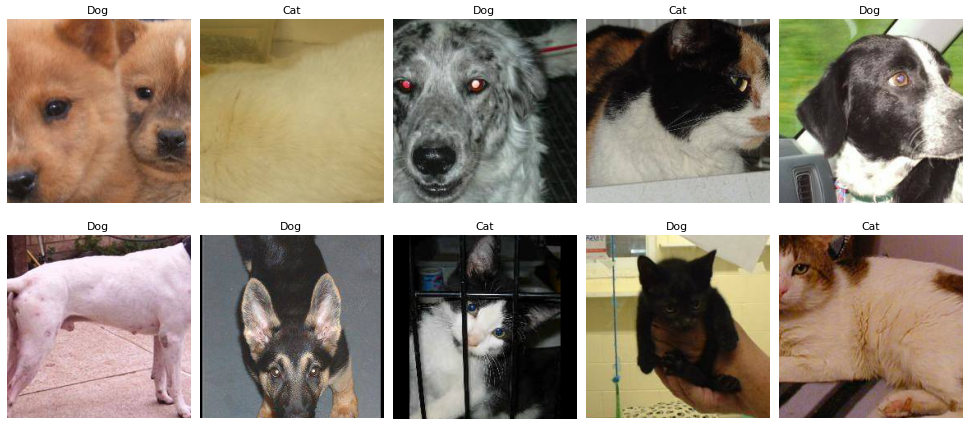

In [13]:
images, labels = next(iter(test_loader))
model.eval()
with torch.no_grad():
  outputs = model(images[0:10])
  outputs = torch.sigmoid(outputs)
  output_perc, output_label = torch.max(outputs, 1)

  viewer(images[0:10], output_label)


## Saving the model

In [ ]:
torch.save(model, '/content/Cat_Dog_Model')